CSV 1: features_line_nostack_20250922T222029Z.csv  -> label: unsized
CSV 2: features_line_nostack_test_20250922T224013Z.csv  -> label: test
Note: first CSV filename has no 'train' tag; if you produce a 'train' CSV later, just swap its path here.


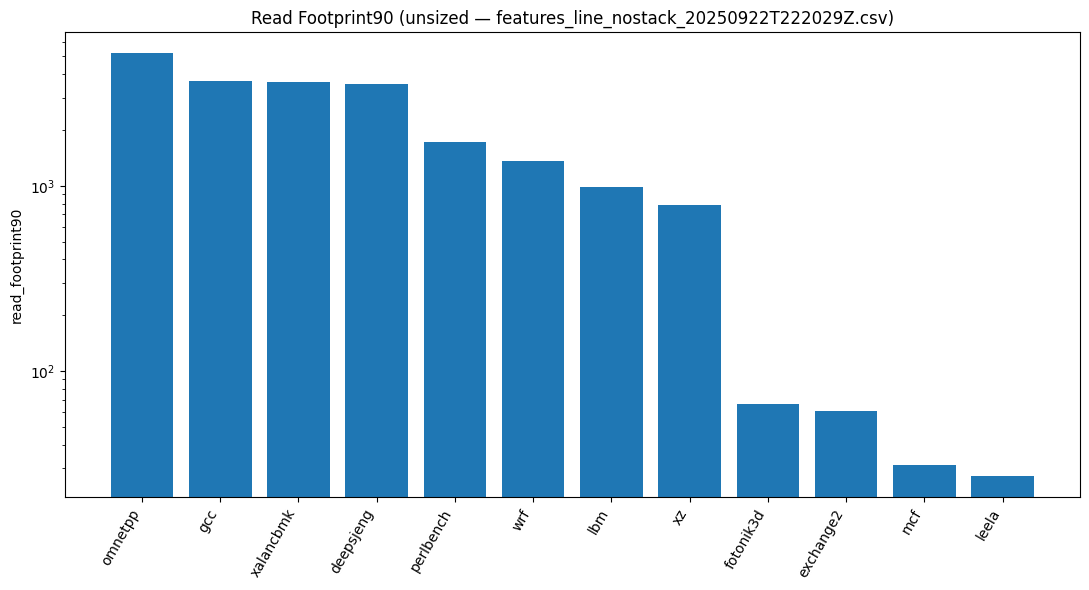

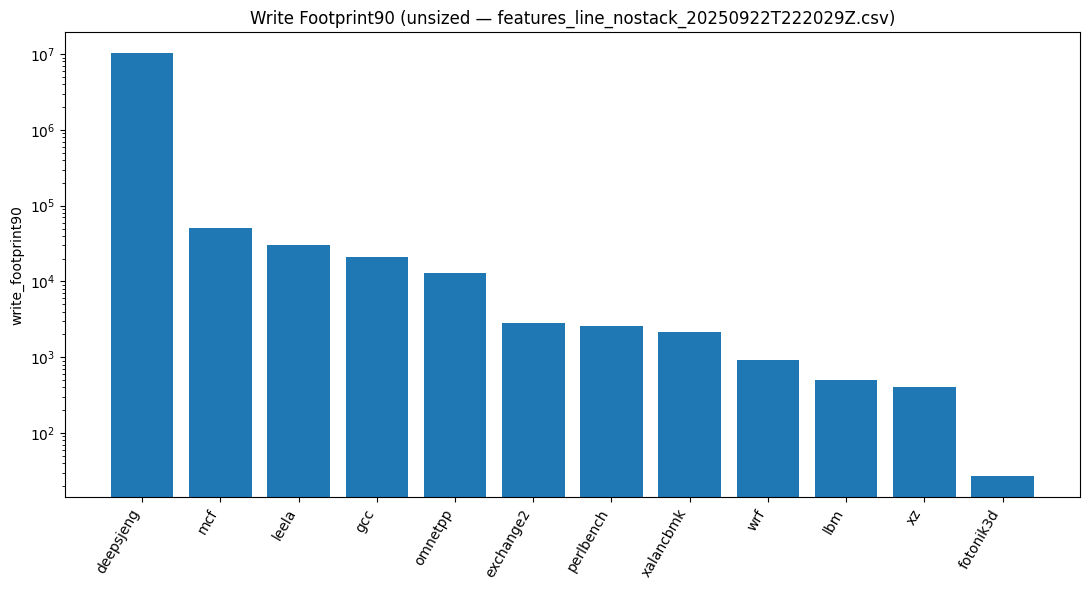

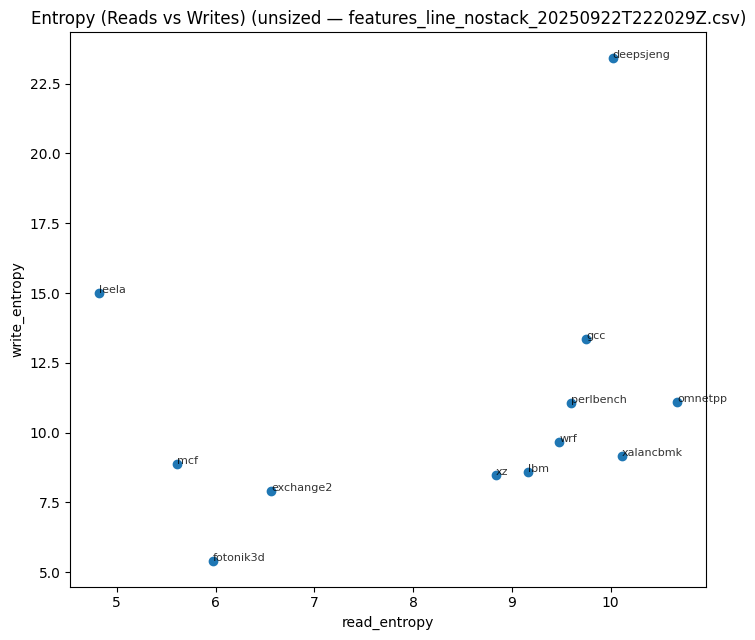

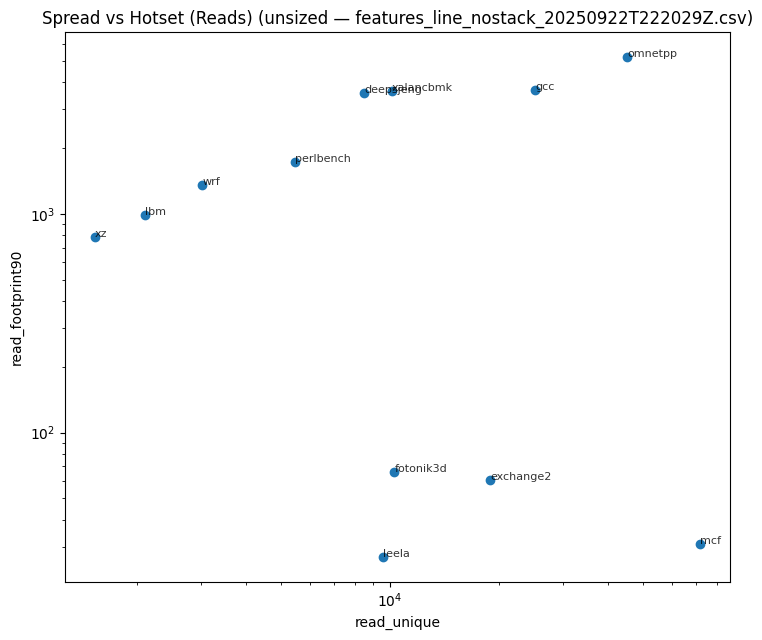

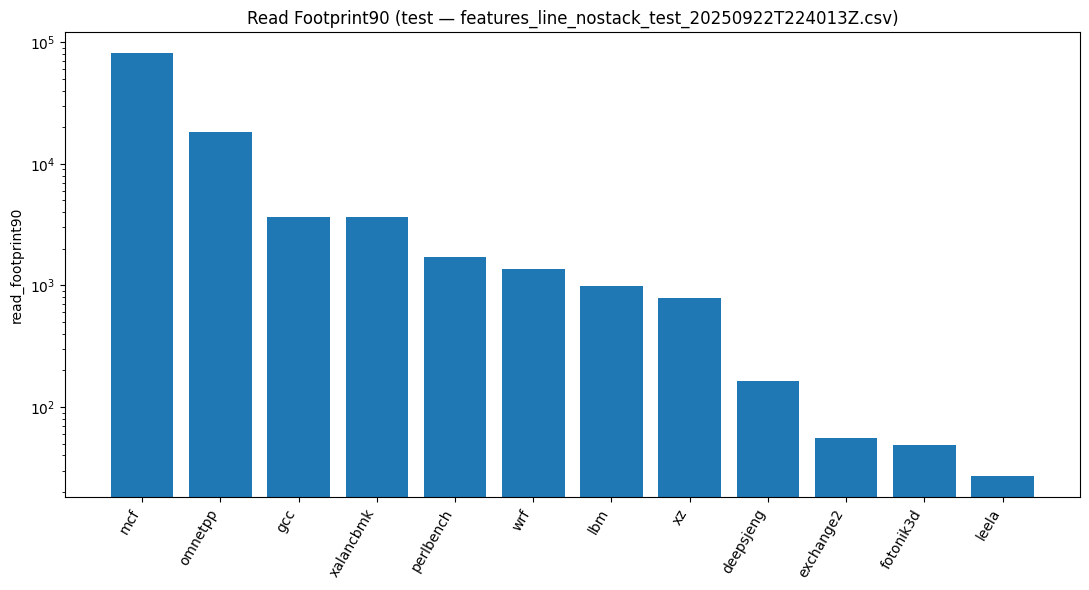

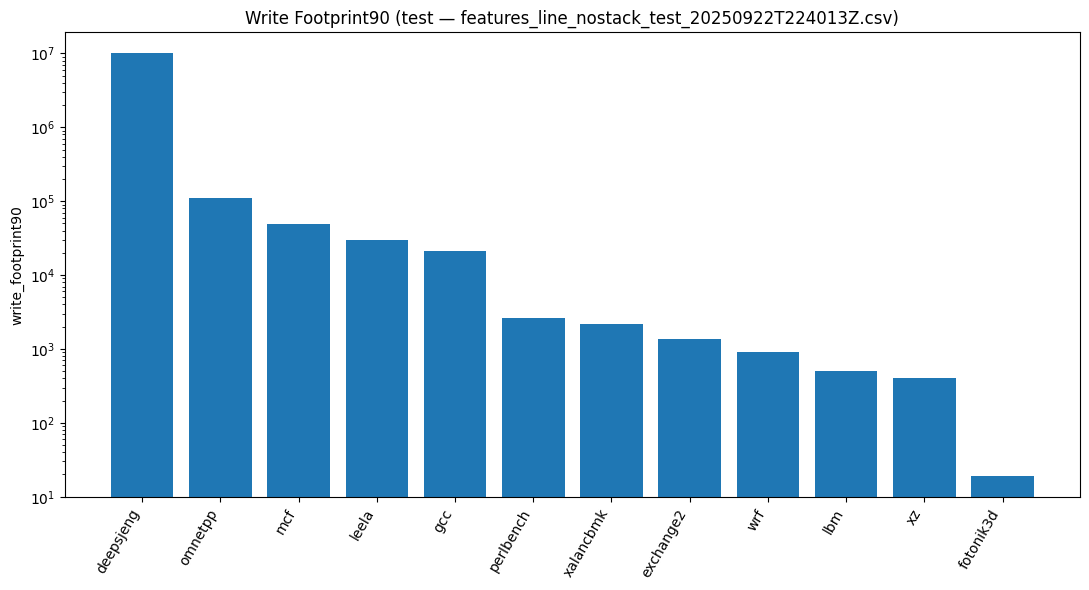

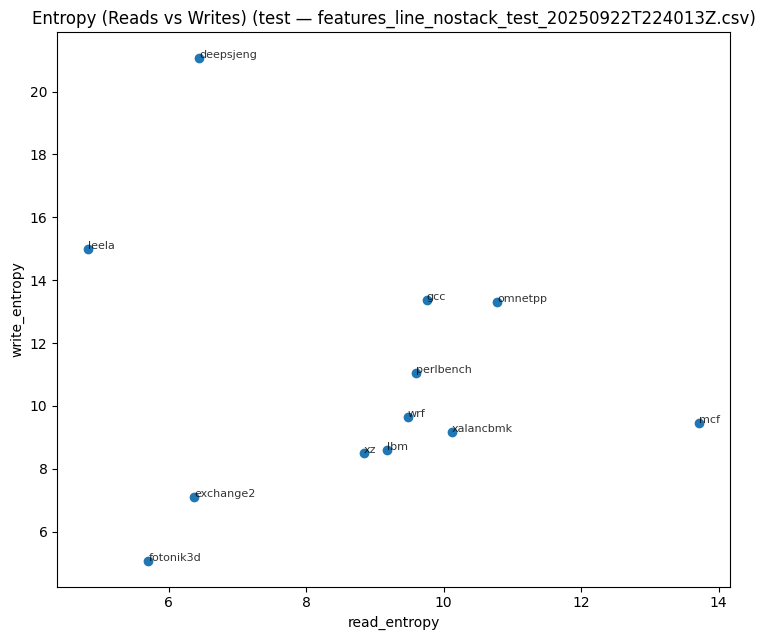

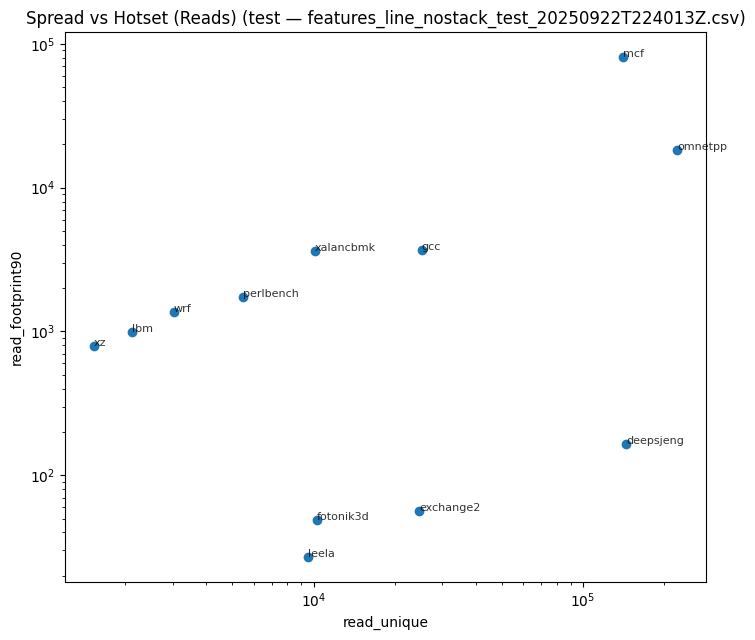

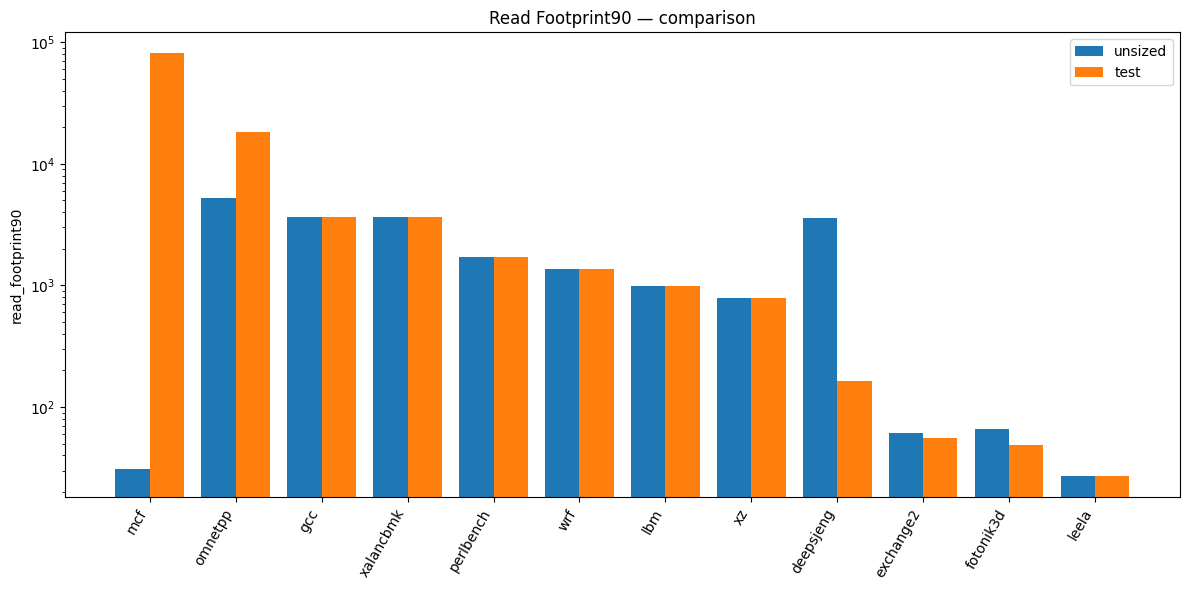

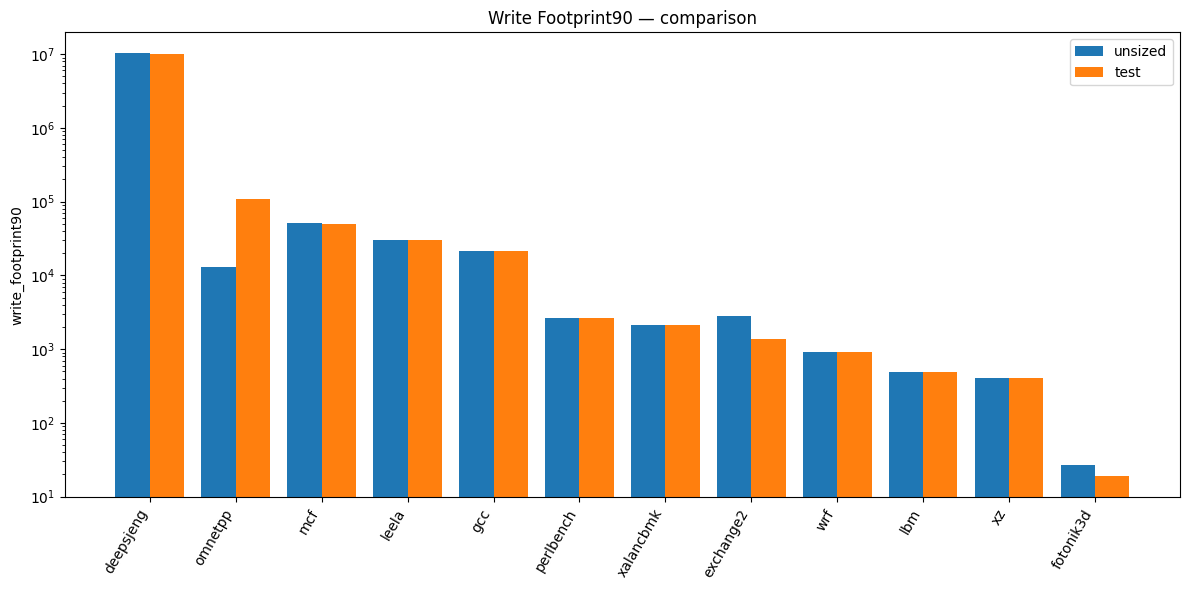

In [8]:
# ONE CELL: 2x3 comparison grid (single figure), uses your two CSVs

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Inline display in Jupyter
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip: ip.run_line_magic("matplotlib", "inline")
except Exception:
    pass

CSV_1 = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_20250922T222029Z.csv"        # (unsized / older)
CSV_2 = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_test_20250922T224013Z.csv"  # (test)

def infer_label(path: str) -> str:
    n = Path(path).name.lower()
    if "_train_" in n: return "train"
    if "_test_" in n: return "test"
    return "unsized"

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    numcols = ["M","read_total","read_unique","read_entropy","read_local_entropy","read_footprint90",
               "write_total","write_unique","write_entropy","write_local_entropy","write_footprint90"]
    for c in numcols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df["label"] = infer_label(path)
    df["source"] = Path(path).name
    return df

def short_name(fullname: str) -> str:
    try:
        return fullname.split(".", 1)[1].split("_", 1)[0]
    except Exception:
        return fullname

df1 = load_csv(CSV_1)
df2 = load_csv(CSV_2)
lab1, lab2 = df1["label"].iloc[0], df2["label"].iloc[0]

# Join on benchmark name so bars align
m = df1.merge(df2, on="name", suffixes=(f" ({lab1})", f" ({lab2})"))
if m.empty:
    raise SystemExit("No overlapping benchmarks between the two CSVs.")

# Sort order: by test (or second) read_footprint90 descending for readability
m = m.sort_values(f"read_footprint90 ({lab2})", ascending=False).reset_index(drop=True)

# Helper to draw side-by-side bars on a given axes
def bars_compare(ax, dfm, col, title, logy=False):
    a, b = f"{col} ({lab1})", f"{col} ({lab2})"
    x = range(len(dfm))
    w = 0.4
    ax.bar([i - w/2 for i in x], dfm[a], width=w, label=lab1)
    ax.bar([i + w/2 for i in x], dfm[b], width=w, label=lab2)
    if logy: ax.set_yscale("log")
    ax.set_xticks(list(x))
    ax.set_xticklabels([short_name(n) for n in dfm["name"]], rotation=60, ha="right")
    ax.set_title(title)
    ax.set_ylabel(col)

# Helper to draw overlaid scatters on a given axes
def scatter_compare(ax, d1, d2, xcol, ycol, title, logx=False, logy=False):
    ax.scatter(d1[xcol], d1[ycol], alpha=0.8, label=lab1)
    ax.scatter(d2[xcol], d2[ycol], alpha=0.8, label=lab2)
    if logx: ax.set_xscale("log")
    if logy: ax.set_yscale("log")
    ax.set_xlabel(xcol); ax.set_ylabel(ycol); ax.set_title(title)

# Build single figure with 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# 1) Read Footprint90 (bars, log scale)
bars_compare(axs[0,0], m, "read_footprint90", "Read Footprint90 (line, no-stack)", logy=True)

# 2) Write Footprint90 (bars, log scale)
bars_compare(axs[0,1], m, "write_footprint90", "Write Footprint90 (line, no-stack)", logy=True)

# 3) Entropy scatter (reads vs writes)
# Pull aligned rows for each label
cols1 = [c for c in m.columns if c.endswith(f"({lab1})")]
cols2 = [c for c in m.columns if c.endswith(f"({lab2})")]
d1 = m[["name"] + cols1].copy()
d2 = m[["name"] + cols2].copy()
# rename back to base names for plotting
d1.columns = [c.split(" (")[0] for c in d1.columns]
d2.columns = [c.split(" (")[0] for c in d2.columns]
scatter_compare(axs[0,2], d1, d2, "read_entropy", "write_entropy", "Entropy: Reads vs Writes")

# 4) Read spread vs hotset (log-log)
scatter_compare(axs[1,0], d1, d2, "read_unique", "read_footprint90",
                "Reads: Unique vs Footprint90", logx=True, logy=True)

# 5) Write spread vs hotset (log-log)
scatter_compare(axs[1,1], d1, d2, "write_unique", "write_footprint90",
                "Writes: Unique vs Footprint90", logx=True, logy=True)

# 6) Read vs Write totals (bars, log scale) — quick workload scale view
bars_compare(axs[1,2], m, "read_total", "Read Total (ops)", logy=True)
# (If you prefer write_total here, swap the col name above)

# Shared legend at top-right
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

fig.suptitle(f"SPEC memory features — {Path(CSV_1).name} vs {Path(CSV_2).name}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()
